In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/pchaberski/projects/image-embeddings')

In [3]:
from utils.configuration import load_config
from data.hm_data import HMDataset

In [4]:
cfg = load_config('config.yml')

In [6]:
data = HMDataset(
    data_path=cfg.get('data_path'),
    image_size=cfg.get('image_size')
)

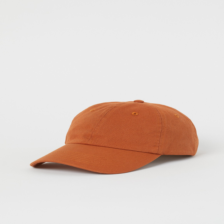

In [9]:
data[77]